# Multiclass Classification using VGG-16 Transfer Learning

In [ ]:
# --- Import Libraries ---
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.utils.class_weight import compute_class_weight
import shutil
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import pandas as pd
import io
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import io
import time

In [2]:
# --- Setup ---
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 3

In [3]:
# --- Define Data Paths ---
original_data_dir = '/Users/reamy/Desktop/THESIS/MC_dataset copy'  
# original_data_dir/
#   ├── PatchWork/
#   ├── Block/
#   ├── Shading/
#   └── Single/
base_dir = 'data/processed1'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val') 




In [4]:
# Create directories
for split in ['train', 'val']:
    for cls in ['PatchWork', 'Block', 'Single']:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

# Split and copy images
for cls in ['PatchWork', 'Block', 'Single']:
    cls_dir = os.path.join(original_data_dir, cls)
    images = os.listdir(cls_dir)
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

    for img in train_images:
        shutil.copy(os.path.join(cls_dir, img), os.path.join(train_dir, cls, img))
    for img in val_images:
        shutil.copy(os.path.join(cls_dir, img), os.path.join(val_dir, cls, img))


In [5]:
# --- Data Generators ---
datagen =ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

print("Class mapping:", train_gen.class_indices)

Found 85 images belonging to 3 classes.
Found 23 images belonging to 3 classes.
Class mapping: {'Block': 0, 'PatchWork': 1, 'Single': 2}


In [ ]:


# --- Load VGG16 base model ---
base_model = tf.keras.applications.VGG16(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze base

# --- Build the full model ---
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')  # ✅ 4 output classes
])

# --- Compile the model ---
model.compile(
    optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0001),
    loss='categorical_crossentropy',  # ✅ correct for one-hot encoded multiclass
    metrics=['accuracy', Precision(), Recall(), AUC()]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,739 (56.38 MB)

 Trainable params: 66,051 (258.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
# --- Custom Callback to Track Metrics ---
val_labels = np.concatenate([val_gen[i][1] for i in range(len(val_gen))])
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_gen, val_labels):
        self.val_generator = val_gen
        self.val_labels = val_labels.reshape(-1).astype(int)
        self.results = []

    def on_epoch_end(self, epoch, logs=None):
        val_predictions = model.predict(self.val_generator)
        val_predictions = (val_predictions > 0.5).astype(int).reshape(-1)

        precision = precision_score(self.val_labels, val_predictions)
        recall = recall_score(self.val_labels, val_predictions)
        f1 = f1_score(self.val_labels, val_predictions)

        self.results.append({
            'Epoch': epoch + 1,
            'Training Accuracy': logs['accuracy'],
            'Validation Accuracy': logs['val_accuracy'],
            'Training Loss': logs['loss'],
            'Validation Loss': logs['val_loss'],
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })

        print(f"Epoch {epoch + 1}: Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={f1:.4f}")

metrics_callback = MetricsCallback(val_gen, val_labels)

In [14]:
# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=5,
    restore_best_weights=True
)

# Save the best model only
checkpoint = ModelCheckpoint(
    filepath='best_vgg16_MC_model.h5',          # file to save the best model
    monitor='val_loss',                # metric to monitor
    save_best_only=True,               # save only if it's the best so far
    mode='min',                        # because we want to minimize loss
    verbose=1                          # print when saving
)

In [15]:
# --- Train the Model ---
class_weights = compute_class_weight('balanced',
                                     classes=np.unique(train_gen.classes),
                                     y=train_gen.classes)
#starting timer
start_time=time.time()
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    callbacks=[metrics_callback,early_stop,checkpoint],class_weight=dict(enumerate(class_weights)))
# End timer
end_time = time.time()
# Calculate and print elapsed time
elapsed_time = end_time - start_time
print(f"\nTraining completed in {elapsed_time:.2f} seconds ({elapsed_time / 60:.2f} minutes).")

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1756 - auc_1: 0.3893 - loss: 1.2988 - precision_1: 0.1269 - recall_1: 0.0685

/Users/reamy/Desktop/THESIS/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Epoch 1: Precision=0.0000, Recall=0.0000, F1 Score=0.0000

Epoch 1: val_loss improved from inf to 1.26372, saving model to best_vgg16_MC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 6s/step - accuracy: 0.1758 - auc_1: 0.3887 - loss: 1.2923 - precision_1: 0.1340 - recall_1: 0.0719 - val_accuracy: 0.1304 - val_auc_1: 0.3762 - val_loss: 1.2637 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2360 - auc_1: 0.4210 - loss: 1.2541 - precision_1: 0.2636 - recall_1: 0.157
Epoch 2: Precision=0.0000, Recall=0.0000, F1 Score=0.0000

Epoch 2: val_loss improved from 1.26372 to 1.22361, saving model to best_vgg16_MC_model.h5


/Users/reamy/Desktop/THESIS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 5s/step - accuracy: 0.2447 - auc_1: 0.4239 - loss: 1.2504 - precision_1: 0.2685 - recall_1: 0.1625 - val_accuracy: 0.1304 - val_auc_1: 0.3313 - val_loss: 1.2236 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3802 - auc_1: 0.4715 - loss: 1.2941 - precision_1: 0.2597 - recall_1: 0.122
Epoch 3: Precision=0.0000, Recall=0.0000, F1 Score=0.0000

Epoch 3: val_loss improved from 1.22361 to 1.19534, saving model to best_vgg16_MC_model.h5


/Users/reamy/Desktop/THESIS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 6s/step - accuracy: 0.3616 - auc_1: 0.4655 - loss: 1.2941 - precision_1: 0.2645 - recall_1: 0.1274 - val_accuracy: 0.1304 - val_auc_1: 0.3223 - val_loss: 1.1953 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2412 - auc_1: 0.4091 - loss: 1.3415 - precision_1: 0.2993 - recall_1: 0.133
Epoch 4: Precision=0.0000, Recall=0.0000, F1 Score=0.0000

Epoch 4: val_loss improved from 1.19534 to 1.16958, saving model to best_vgg16_MC_model.h5


/Users/reamy/Desktop/THESIS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - accuracy: 0.2368 - auc_1: 0.4067 - loss: 1.3351 - precision_1: 0.2939 - recall_1: 0.1291 - val_accuracy: 0.1304 - val_auc_1: 0.3233 - val_loss: 1.1696 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3751 - auc_1: 0.5514 - loss: 1.1263 - precision_1: 0.3228 - recall_1: 0.163
Epoch 5: Precision=0.0000, Recall=0.0000, F1 Score=0.0000

Epoch 5: val_loss improved from 1.16958 to 1.14903, saving model to best_vgg16_MC_model.h5


/Users/reamy/Desktop/THESIS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 6s/step - accuracy: 0.3637 - auc_1: 0.5417 - loss: 1.1430 - precision_1: 0.3127 - recall_1: 0.1611 - val_accuracy: 0.1304 - val_auc_1: 0.3398 - val_loss: 1.1490 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3486 - auc_1: 0.4644 - loss: 1.1770 - precision_1: 0.2222 - recall_1: 0.092
Epoch 6: Precision=0.0000, Recall=0.0000, F1 Score=0.0000

Epoch 6: val_loss improved from 1.14903 to 1.13929, saving model to best_vgg16_MC_model.h5


/Users/reamy/Desktop/THESIS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 6s/step - accuracy: 0.3497 - auc_1: 0.4672 - loss: 1.1836 - precision_1: 0.2292 - recall_1: 0.0956 - val_accuracy: 0.1304 - val_auc_1: 0.3166 - val_loss: 1.1393 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2425 - auc_1: 0.4454 - loss: 1.2456 - precision_1: 0.2739 - recall_1: 0.153
Epoch 7: Precision=0.0000, Recall=0.0000, F1 Score=0.0000

Epoch 7: val_loss improved from 1.13929 to 1.12074, saving model to best_vgg16_MC_model.h5


/Users/reamy/Desktop/THESIS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 6s/step - accuracy: 0.2348 - auc_1: 0.4379 - loss: 1.2539 - precision_1: 0.2664 - recall_1: 0.1448 - val_accuracy: 0.2609 - val_auc_1: 0.3677 - val_loss: 1.1207 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2008 - auc_1: 0.4271 - loss: 1.2496 - precision_1: 0.2071 - recall_1: 0.113
Epoch 8: Precision=0.0000, Recall=0.0000, F1 Score=0.0000

Epoch 8: val_loss improved from 1.12074 to 1.11088, saving model to best_vgg16_MC_model.h5


/Users/reamy/Desktop/THESIS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 6s/step - accuracy: 0.2035 - auc_1: 0.4267 - loss: 1.2563 - precision_1: 0.2064 - recall_1: 0.1115 - val_accuracy: 0.0870 - val_auc_1: 0.3790 - val_loss: 1.1109 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3442 - auc_1: 0.4886 - loss: 1.4814 - precision_1: 0.1798 - recall_1: 0.088
Epoch 9: Precision=0.0000, Recall=0.0000, F1 Score=0.0000

Epoch 9: val_loss improved from 1.11088 to 1.10286, saving model to best_vgg16_MC_model.h5


/Users/reamy/Desktop/THESIS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 7s/step - accuracy: 0.3405 - auc_1: 0.4880 - loss: 1.4503 - precision_1: 0.1824 - recall_1: 0.0900 - val_accuracy: 0.3478 - val_auc_1: 0.4943 - val_loss: 1.1029 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3013 - auc_1: 0.5200 - loss: 1.2778 - precision_1: 0.2722 - recall_1: 0.146
Epoch 10: Precision=0.0000, Recall=0.0000, F1 Score=0.0000

Epoch 10: val_loss improved from 1.10286 to 1.10197, saving model to best_vgg16_MC_model.h5


/Users/reamy/Desktop/THESIS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 7s/step - accuracy: 0.2907 - auc_1: 0.5115 - loss: 1.2669 - precision_1: 0.2610 - recall_1: 0.1395 - val_accuracy: 0.3043 - val_auc_1: 0.4598 - val_loss: 1.1020 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2464 - auc_1: 0.4657 - loss: 1.3168 - precision_1: 0.2669 - recall_1: 0.131
Epoch 11: Precision=0.0000, Recall=0.0000, F1 Score=0.0000

Epoch 11: val_loss improved from 1.10197 to 1.09251, saving model to best_vgg16_MC_model.h5


/Users/reamy/Desktop/THESIS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - accuracy: 0.2525 - auc_1: 0.4667 - loss: 1.2901 - precision_1: 0.2689 - recall_1: 0.1311 - val_accuracy: 0.3043 - val_auc_1: 0.5411 - val_loss: 1.0925 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3641 - auc_1: 0.5112 - loss: 1.2675 - precision_1: 0.3316 - recall_1: 0.165
Epoch 12: Precision=0.0000, Recall=0.0000, F1 Score=0.0000

Epoch 12: val_loss improved from 1.09251 to 1.08087, saving model to best_vgg16_MC_model.h5


/Users/reamy/Desktop/THESIS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 7s/step - accuracy: 0.3613 - auc_1: 0.5146 - loss: 1.2587 - precision_1: 0.3362 - recall_1: 0.1652 - val_accuracy: 0.5217 - val_auc_1: 0.6876 - val_loss: 1.0809 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4933 - auc_1: 0.6180 - loss: 1.0605 - precision_1: 0.3917 - recall_1: 0.191
Epoch 13: Precision=0.0000, Recall=0.0000, F1 Score=0.0000

Epoch 13: val_loss improved from 1.08087 to 1.07826, saving model to best_vgg16_MC_model.h5


/Users/reamy/Desktop/THESIS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 7s/step - accuracy: 0.4877 - auc_1: 0.6201 - loss: 1.0559 - precision_1: 0.3984 - recall_1: 0.1968 - val_accuracy: 0.4783 - val_auc_1: 0.6848 - val_loss: 1.0783 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2517 - auc_1: 0.4460 - loss: 1.1981 - precision_1: 0.2618 - recall_1: 0.143
Epoch 14: Precision=0.0000, Recall=0.0000, F1 Score=0.0000

Epoch 14: val_loss did not improve from 1.07826
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 7s/step - accuracy: 0.2564 - auc_1: 0.4446 - loss: 1.2157 - precision_1: 0.2724 - recall_1: 0.1488 - val_accuracy: 0.5652 - val_auc_1: 0.6621 - val_loss: 1.0807 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 15/50


/Users/reamy/Desktop/THESIS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2972 - auc_1: 0.4894 - loss: 1.2952 - precision_1: 0.3126 - recall_1: 0.154
Epoch 15: Precision=0.0000, Recall=0.0000, F1 Score=0.0000

Epoch 15: val_loss improved from 1.07826 to 1.07291, saving model to best_vgg16_MC_model.h5


/Users/reamy/Desktop/THESIS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 8s/step - accuracy: 0.2964 - auc_1: 0.4883 - loss: 1.2823 - precision_1: 0.3155 - recall_1: 0.1512 - val_accuracy: 0.4783 - val_auc_1: 0.7108 - val_loss: 1.0729 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4237 - auc_1: 0.6053 - loss: 1.0995 - precision_1: 0.4491 - recall_1: 0.187
Epoch 16: Precision=0.0000, Recall=0.0000, F1 Score=0.0000

Epoch 16: val_loss improved from 1.07291 to 1.07287, saving model to best_vgg16_MC_model.h5


/Users/reamy/Desktop/THESIS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 7s/step - accuracy: 0.4207 - auc_1: 0.6050 - loss: 1.1007 - precision_1: 0.4511 - recall_1: 0.1879 - val_accuracy: 0.6522 - val_auc_1: 0.7647 - val_loss: 1.0729 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2298 - auc_1: 0.4632 - loss: 1.2002 - precision_1: 0.1392 - recall_1: 0.0707     
Epoch 17: Precision=0.0000, Recall=0.0000, F1 Score=0.0000

Epoch 17: val_loss did not improve from 1.07287
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 7s/step - accuracy: 0.2429 - auc_1: 0.4728 - loss: 1.1978 - precision_1: 0.1626 - recall_1: 0.0824 - val_accuracy: 0.6522 - val_auc_1: 0.7505 - val_loss: 1.0755 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 18/50


/Users/reamy/Desktop/THESIS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2836 - auc_1: 0.4843 - loss: 1.2155 - precision_1: 0.3757 - recall_1: 0.157
Epoch 18: Precision=0.0000, Recall=0.0000, F1 Score=0.0000

Epoch 18: val_loss did not improve from 1.07287
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - accuracy: 0.2921 - auc_1: 0.4955 - loss: 1.1982 - precision_1: 0.3790 - recall_1: 0.1592 - val_accuracy: 0.6957 - val_auc_1: 0.7235 - val_loss: 1.0788 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 19/50


/Users/reamy/Desktop/THESIS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3820 - auc_1: 0.5801 - loss: 1.1604 - precision_1: 0.3939 - recall_1: 0.238
Epoch 19: Precision=0.0000, Recall=0.0000, F1 Score=0.0000

Epoch 19: val_loss did not improve from 1.07287
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - accuracy: 0.3777 - auc_1: 0.5738 - loss: 1.1608 - precision_1: 0.3821 - recall_1: 0.2289 - val_accuracy: 0.5652 - val_auc_1: 0.6942 - val_loss: 1.0839 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 20/50


/Users/reamy/Desktop/THESIS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3741 - auc_1: 0.5633 - loss: 1.1311 - precision_1: 0.4059 - recall_1: 0.170
Epoch 20: Precision=0.0000, Recall=0.0000, F1 Score=0.0000

Epoch 20: val_loss did not improve from 1.07287
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 7s/step - accuracy: 0.3659 - auc_1: 0.5539 - loss: 1.1514 - precision_1: 0.3973 - recall_1: 0.1663 - val_accuracy: 0.5217 - val_auc_1: 0.7164 - val_loss: 1.0814 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 21/50


/Users/reamy/Desktop/THESIS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3093 - auc_1: 0.5331 - loss: 1.1497 - precision_1: 0.3498 - recall_1: 0.178
Epoch 21: Precision=0.0000, Recall=0.0000, F1 Score=0.0000

Epoch 21: val_loss did not improve from 1.07287
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - accuracy: 0.3026 - auc_1: 0.5282 - loss: 1.1592 - precision_1: 0.3477 - recall_1: 0.1748 - val_accuracy: 0.4348 - val_auc_1: 0.6281 - val_loss: 1.0905 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00


/Users/reamy/Desktop/THESIS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


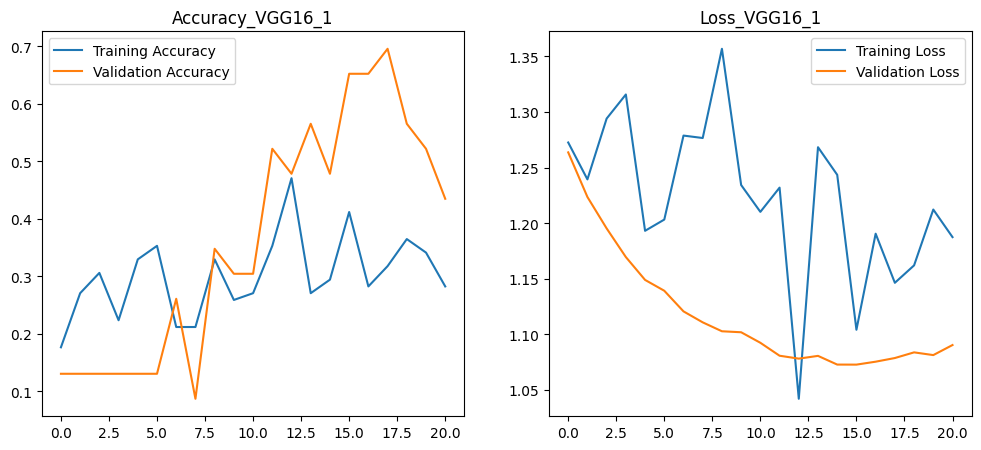

In [16]:
# --- Plot Training Curves ---
def plot_history(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy_VGG16_1')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Loss_VGG16_1')

    plt.show()

plot_history(history)

In [ ]:
# --- Save Metrics to CSV ---
results_df1 = pd.DataFrame(metrics_callback.results)
results_file_path = os.path.join(os.getcwd(), 'training_results1.csv')
results_df1.to_csv(results_file_path, index=False)
print(f"Training results saved to {results_file_path}")

# --- Plotting Metrics ---
metrics = ['Precision', 'Recall', 'F1 Score', 'Training Accuracy', 'Validation Accuracy', 'Training Loss', 'Validation Loss']
titles = ['Precision_vgg16_1', 'Recall_vgg16_1', 'F1 Score_vgg16_1', 'Training Accuracy_vgg16_1', 'Validation Accuracy_vgg16_1', 'Training Loss_vgg16_1', 'Validation Loss_vgg16_1']
file_names = ['precision_plot_vgg16_1.png', 'recall_plot_vgg16_1.png', 'f1_score_plot_vgg16_1.png',
              'training_accuracy_plot_vgg16_1.png', 'validation_accuracy_plot_vgg16_1.png',
              'training_loss_plot_vgg16_1.png', 'validation_loss_plot_vgg16_1.png']

for i, metric in enumerate(metrics):
    plt.figure(figsize=(8, 5))
    plt.plot(results_df1[metric], label=metric, linewidth=2, color='green')# marker='o')
    plt.title(titles[i], fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=10)

    # Annotate last value
    last_epoch = len(results_df1[metric]) - 1
    last_value = results_df1[metric].iloc[-1]
    plt.annotate(f"{last_value:.4f}",
                 xy=(last_epoch, last_value),
                 xytext=(last_epoch, last_value + 0.02),
                 ha='center',
                 fontsize=10,
                 bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="black", lw=1))

    plt.tight_layout()
    plt.savefig(file_names[i], dpi=300)
    plt.close()

print("All plots saved successfully.")

In [ ]:
# --- Evaluation ---
val_gen.reset()
predictions = model.predict(val_gen)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap='Reds')
plt.title('Confusion Matrix for VGG-16')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [ ]:
report_dict = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)
class_results = pd.DataFrame(report_dict).transpose()

# (Optional) Save to CSV
class_results.to_csv("classification_report.csv")

# Show preview
print(class_results)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Get a batch of images and labels
images, labels = next(val_gen)

# Number of images to display
N = 5

# Randomly choose N indices from the batch
indices = random.sample(range(images.shape[0]), N)

# Get class labels
class_labels = list(val_gen.class_indices.keys())

# Plot images with predictions
plt.figure(figsize=(15, 5))

for i, idx in enumerate(indices):
    img = images[idx]
    true_label = np.argmax(labels[idx])

    # Predict
    pred = model.predict(img[np.newaxis, ...], verbose=0)
    pred_label = np.argmax(pred)

    # Plot image
    plt.subplot(1, N, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {class_labels[true_label]}\nPred: {class_labels[pred_label]}")

plt.tight_layout()
plt.show()